In [12]:
from IPython.display import clear_output

In [13]:
%pip install torch torchvision
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install tqdm

clear_output()

## Contents

In this notebook, we will use a pre-trained model to do similar image search/retrieval

1. The idea is, we use a pre-trained image model to extract features / embeddings of a set of images
2. Then we use PCA to reduce the dimensions of these features (The searching will still work without PCA but dimensionality reduction helps with the speed of the model)
3. We will then pick a random image from the sample which will be our query image. We'll calculate the cosine similarity of the pca features of the query image with the pca features of all the images and pick the top images

We will use Caltech 101 object categories dataset because of the high quality of images.

You need to know:

1. pytorch and numpy (for impelementation)
2. a bit of torch dataloaders and datasets (not necessary but helps understanding how we're loading data)
3. Sklearn (not necessaru but we're using functions from it to calculate cosine similarity and PCA)
4. PCA (Principle Component Analysis) (Details and implementation knowledge not needed but good to know why it's used)
5. A little bit of matplotlib (for visualizing the results/images)

In [1]:
import random

import numpy as np

import torch
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms
from torchvision import models

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# For reproducable results. Can be skipped/commented.
torch.manual_seed(7)
random.seed(7)

## Downloading and Loading Images

In [3]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

############################################################################################# 100.0%
Archive:  101_ObjectCategories.zip
replace __MACOSX/._caltech-101? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._caltech-101  
  inflating: caltech-101/101_ObjectCategories.tar.gz  

  inflating: __MACOSX/caltech-101/._101_ObjectCategories.tar.gz  
  inflating: caltech-101/show_annotation.m  
  inflating: __MACOSX/caltech-101/._show_annotation.m  
  inflating: caltech-101/Annotations.tar  
  inflating: __MACOSX/caltech-101/._Annotations.tar  
101_ObjectCategories  101_ObjectCategories.zip	caltech-101  data  del	__MACOSX  sample_data


In [4]:
batch_size = 64  # for batched. feature extraction
n_images = 1000  # num images to keep in the dataset.
n_pca_components = 300  # hyper param for number of top params to keep after PCA

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# image_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)  # dataset can be replaced with CIFAR10
image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)
random_indices = random.sample(range(len(image_dataset)), n_images)
images_subset = Subset(image_dataset, random_indices)

image_loader = DataLoader(images_subset, batch_size, shuffle=False, num_workers=2)

## Downloading and Loading model

In [6]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval().to(device)


def extract_features(image_tensor: torch.Tensor):

    image_tensor = image_tensor.to(device)

    # Dont need to compute gradients because we're not training the model. It's pre-trained
    # We're passing by each layer manually because we don't want to pass the data through the ENTIRE model.
    # We wanna skip the last one or 2 layers so we don't get class probabilities (incase of classifier model) but the features representing the images
    with torch.no_grad():
        features = vgg16.features(image_tensor)
        features = features.view(features.size(0), -1)
        features = vgg16.classifier[0](features)
        features = vgg16.classifier[1](features)
        features = vgg16.classifier[2](features)

    return features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Extracting model features for all images

In [7]:
all_features = torch.Tensor().to(device)
image_tensors = torch.Tensor()  # No need to push this to device. We wanna keep this on CPU

for image_batch, _ in tqdm(image_loader):

    image_tensors = torch.cat((image_tensors, image_batch), dim=0)

    batch_features = extract_features(image_batch)
    all_features = torch.cat((all_features, batch_features), dim=0)

all_features = all_features.cpu().numpy()  # need numpy for PCA. need cpu for numpy.

print('')  # empty line
print(f'{image_tensors.shape=}')
print(f'{all_features.shape=}')

100%|██████████| 16/16 [00:06<00:00,  2.29it/s]

image_tensors.shape=torch.Size([1000, 3, 224, 224])
all_features.shape=(1000, 4096)


## Extracting PCA features

In [8]:
pca = PCA(n_components=n_pca_components)
pca_features = pca.fit_transform(all_features)

## Let's get to image searching

you can rerun this cell multiple times for different random results

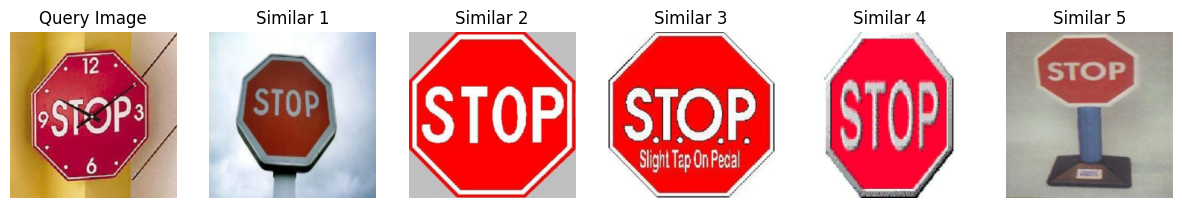

In [10]:
random_image_index = random.randint(0, len(pca_features) - 1)
random_image = image_tensors[random_image_index]
image_features = pca_features[random_image_index]

cosine_similarities = cosine_similarity(pca_features, image_features.reshape(1, -1)).reshape(-1)

# from the end because higher cosine similarity = more similar and argsort sorts ascendingly
# -6:-1 instead of -5: because the last image (most similar) would be the query image itself. ::-1 to reverse (bring most similar to idx 0)
similar_indices = cosine_similarities.argsort()[-6:-1][::-1]

# Display the images
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(random_image.squeeze().permute(1, 2, 0).numpy())
plt.title('Query Image')
plt.axis('off')

for i, idx in enumerate(similar_indices):
    image = image_tensors[idx]
    plt.subplot(1, 6, i + 2)
    plt.imshow(image.squeeze().permute(1, 2, 0).numpy())
    plt.title(f'Similar {i+1}')
    plt.axis('off')

plt.show()